In [1]:
import cobra
import os
import glob
import pandas as pd
path = "/home/mac9jc/paradigm/models"
os.chdir(path)

from matplotlib_venn import venn3

# Matplotlib defaults
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
#Rivanna fonts should include sans-serif now, but this could still raise an error
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

SMALLER_SIZE = 8
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
model_dict = dict()

species_to_evaluate = ['PbergheiANKA','Pfalciparum3D7','PfalciparumDd2','TgondiiGT1','TgondiiME49']
models_to_evaluate = ['for_sensitivity_gf_','for_sensitivity_gf_no_ortho_','gf_','gf_no_ortho_',]
model_list = list()
for species in species_to_evaluate:
    for model_type in models_to_evaluate:
        model_list.append(model_type+species+'.xml')

for filename in model_list:
    if os.path.isfile(filename):
        key = filename[:-4]
        model_dict[key] = cobra.io.read_sbml_model(filename)

In [3]:
# blocked reactions
blocked_rxn = dict()
for species_String, model in model_dict.items():
    
    if 'Pfalciparum3D7' in species_String: species = 'Pfalciparum3D7'  
    elif 'PfalciparumDd2' in species_String: species = 'PfalciparumDd2'
    elif 'PbergheiANKA' in species_String: species = 'PbergheiANKA'
    elif 'TgondiiME49' in species_String: species = 'TgondiiME49'
    elif 'TgondiiGT1' in species_String: species = 'TgondiiGT1'
    else: print(species_String) 
    
    if 'for_sensitivity_' in species_String:
        species_String_new = species_String.split('for_sensitivity_')[1]
        compartment = 'no'
    else:
        species_String_new = species_String
        compartment = 'yes' 
        
    blocked_down_rxns = list()
    blocked_up_rxns = list()
    both_rxns = list()
    for rxn in model.reactions:
        x = rxn.id
        rxn_products = rxn.products
        rxn_reactants = rxn.reactants
        temp_dict = dict()
        for met in rxn_products:
            temp_dict[met] = [r.id for r in met.reactions if met in r.reactants]
        if len([met.id for met in temp_dict.keys() if len(temp_dict[met])<1])>1:
            blocked_down_rxns.append(x)
        temp_dict = dict()
        for met in rxn_reactants:
            temp_dict[met] = [r.id for r in met.reactions if met in r.products]
        if len([met.id for met in temp_dict.keys() if len(temp_dict[met])<1])>1:
            blocked_up_rxns.append(x)
        if x in blocked_up_rxns and x in blocked_down_rxns:
            both_rxns.append(x)
    
    blocked_only_up = set(blocked_up_rxns).difference(set(both_rxns))
    blocked_only_down = set(blocked_down_rxns).difference(set(both_rxns))
    blocked_rxn[species_String] = {'species':species,
                                'with compartments':compartment,
                                'curation_stage':species_String_new.split(species)[0],
                                'blocked_rxns':len(blocked_only_down),
                                  'unconnected_upstream':len(blocked_only_up),
                                  'blocked_both':len(both_rxns)}
    
df = pd.DataFrame.from_dict(blocked_rxn, orient='index')

In [4]:
#p berghei ANKA
species_df = df[df['species'] == 'PbergheiANKA']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pb_gf = species_df_with_gf- species_df_wo_gf
pb_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum 3D7
species_df = df[df['species'] == 'Pfalciparum3D7']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pf3D7_gf = species_df_with_gf- species_df_wo_gf
pf3D7_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum Dd2
species_df = df[df['species'] == 'PfalciparumDd2']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pfDd2_gf = species_df_with_gf- species_df_wo_gf
pfDd2_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiME49
species_df = df[df['species'] == 'TgondiiME49']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgME49_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiGT1
species_df = df[df['species'] == 'TgondiiGT1']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgGT1_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO


# compile
species = ['PbergheiANKA','PbergheiANKA',\
          'Pfalciparum3D7','Pfalciparum3D7',\
          'PfalciparumDd2','PfalciparumDd2',\
          'TgondiiME49',\
          'TgondiiGT1']
curation = ['gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf_no_ortho',\
           'gf_no_ortho']
df_use = pb_gf.append([pb_gf_noO, pf3D7_gf, pf3D7_gf_noO,pfDd2_gf,pfDd2_gf_noO,\
                      tgME49_gf_noO, tgGT1_gf_noO]).set_index([species, curation])

df_use




blocked_rxns  unconnected_upstream  blocked_both
PbergheiANKA   gf                      6                     8             5
               gf_no_ortho            -2                     7            -1
Pfalciparum3D7 gf                     -1                    16             0
               gf_no_ortho            -3                     5            -1
PfalciparumDd2 gf                     -1                     2             1
               gf_no_ortho           -10                     0            -4
TgondiiME49    gf_no_ortho            -3                     8             0
TgondiiGT1     gf_no_ortho             2                     5             0

In [5]:
df_use.sum(axis=1)

PbergheiANKA    gf             19
                gf_no_ortho     4
Pfalciparum3D7  gf             15
                gf_no_ortho     1
PfalciparumDd2  gf              2
                gf_no_ortho   -14
TgondiiME49     gf_no_ortho     5
TgondiiGT1      gf_no_ortho     7
dtype: int64

In [ ]:
# generally there are more blocked reactions in the compartmentalized models, but thats ok! more function, not surprising

In [7]:
# difference in gene essentiality

gene_dict = dict()
rxn_dict = dict()
res_dict = dict()
for species_String, model in model_dict.items():
    
    if 'Pfalciparum3D7' in species_String: species = 'Pfalciparum3D7'  
    elif 'PfalciparumDd2' in species_String: species = 'PfalciparumDd2'
    elif 'PbergheiANKA' in species_String: species = 'PbergheiANKA'
    elif 'TgondiiME49' in species_String: species = 'TgondiiME49'
    elif 'TgondiiGT1' in species_String: species = 'TgondiiGT1'
    else: print(species_String)        
        
    opt_growth = model.optimize().objective_value
    min_growth = 0.9*opt_growth
    gene_deletion_results = cobra.flux_analysis.single_gene_deletion(model)
    rxn_deletion_results = cobra.flux_analysis.single_reaction_deletion(model)
    gene_dict[species_String] = gene_deletion_results
    rxn_dict[species_String] = rxn_deletion_results
    
    essential_genes = gene_deletion_results[gene_deletion_results['growth'] < min_growth].index
    essential_reactions = rxn_deletion_results[rxn_deletion_results['growth'] < min_growth].index
    
    n_essential_genes = len(essential_genes)
    n_essential_rxns = len(essential_reactions)
    
    if 'for_sensitivity_' in species_String:
        species_String_new = species_String.split('for_sensitivity_')[1]
        compartment = 'no'
    else:
        species_String_new = species_String
        compartment = 'yes'
        
    res_dict[species_String] = {'species':species,
                                'with compartments':compartment,
                                'curation_stage':species_String_new.split(species)[0],
                                'genes':len(model.genes),
                                'reactions':len(model.reactions),
                               'essential_genes':n_essential_genes,
                               'essential_rxns':n_essential_rxns}
    
df = pd.DataFrame.from_dict(res_dict, orient='index')

In [8]:
# get difference in gene essentiality

#p berghei ANKA
species_df = df[df['species'] == 'PbergheiANKA']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pb_gf = species_df_with_gf- species_df_wo_gf
pb_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum 3D7
species_df = df[df['species'] == 'Pfalciparum3D7']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pf3D7_gf = species_df_with_gf- species_df_wo_gf
pf3D7_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum Dd2
species_df = df[df['species'] == 'PfalciparumDd2']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pfDd2_gf = species_df_with_gf- species_df_wo_gf
pfDd2_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiME49
species_df = df[df['species'] == 'TgondiiME49']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgME49_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiGT1
species_df = df[df['species'] == 'TgondiiGT1']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','genes','reactions'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgGT1_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO


# compile
species = ['PbergheiANKA','PbergheiANKA',\
          'Pfalciparum3D7','Pfalciparum3D7',\
          'PfalciparumDd2','PfalciparumDd2',\
          'TgondiiME49',\
          'TgondiiGT1']
curation = ['gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf_no_ortho',\
           'gf_no_ortho']
df_use = pb_gf.append([pb_gf_noO, pf3D7_gf, pf3D7_gf_noO,pfDd2_gf,pfDd2_gf_noO,\
                      tgME49_gf_noO, tgGT1_gf_noO]).set_index([species, curation])

df_use

essential_genes  essential_rxns
PbergheiANKA   gf                        -6             -28
               gf_no_ortho                6              -3
Pfalciparum3D7 gf                         8               0
               gf_no_ortho               -8             -18
PfalciparumDd2 gf                        -1             -11
               gf_no_ortho                4              14
TgondiiME49    gf_no_ortho                0              -4
TgondiiGT1     gf_no_ortho                0              -4

In [9]:
# compile
species = ['PbergheiANKA',\
          'Pfalciparum3D7',\
          'PfalciparumDd2',\
          'TgondiiME49',\
          'TgondiiGT1']
df_use = pb_gf.append([pf3D7_gf, pfDd2_gf,\
                      tgME49_gf_noO, tgGT1_gf_noO]).set_index([species])

df_use

,essential_genes,essential_rxns
PbergheiANKA,-6,-28
Pfalciparum3D7,8,0
PfalciparumDd2,-1,-11
TgondiiME49,0,-4
TgondiiGT1,0,-4


In [ ]:
# generally there are more essential genes and fewer essential reactions in the compartmentalized models

In [10]:
# get difference in model reactions

#p berghei ANKA
species_df = df[df['species'] == 'PbergheiANKA']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pb_gf = species_df_with_gf- species_df_wo_gf
pb_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum 3D7
species_df = df[df['species'] == 'Pfalciparum3D7']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pf3D7_gf = species_df_with_gf- species_df_wo_gf
pf3D7_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#p falciparum Dd2
species_df = df[df['species'] == 'PfalciparumDd2']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_with_gf = species_df_with[species_df_with['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_wo_gf = species_df_wo[species_df_wo['curation_stage'] == 'gf_'].drop(['curation_stage'], axis=1)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
pfDd2_gf = species_df_with_gf- species_df_wo_gf
pfDd2_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiME49
species_df = df[df['species'] == 'TgondiiME49']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgME49_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO

#TgondiiGT1
species_df = df[df['species'] == 'TgondiiGT1']
species_df_with = species_df[species_df['with compartments'] == 'yes'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_with_gf_noO = species_df_with[species_df_with['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
species_df_wo = species_df[species_df['with compartments'] == 'no'].drop(['species','with compartments','essential_genes','essential_rxns'], axis=1).reset_index(drop=True)
species_df_wo_gf_noO = species_df_wo[species_df_wo['curation_stage'] == 'gf_no_ortho_'].drop(['curation_stage'], axis=1)
#difference
tgGT1_gf_noO = species_df_with_gf_noO- species_df_wo_gf_noO


# compile
species = ['PbergheiANKA','PbergheiANKA',\
          'Pfalciparum3D7','Pfalciparum3D7',\
          'PfalciparumDd2','PfalciparumDd2',\
          'TgondiiME49',\
          'TgondiiGT1']
curation = ['gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf','gf_no_ortho',\
            'gf_no_ortho',\
           'gf_no_ortho']
df_use = pb_gf.append([pb_gf_noO, pf3D7_gf, pf3D7_gf_noO,pfDd2_gf,pfDd2_gf_noO,\
                      tgME49_gf_noO, tgGT1_gf_noO]).set_index([species, curation])

df_use

genes  reactions
PbergheiANKA   gf              24        421
               gf_no_ortho     24        264
Pfalciparum3D7 gf              30        248
               gf_no_ortho     30        217
PfalciparumDd2 gf              26        339
               gf_no_ortho     26        157
TgondiiME49    gf_no_ortho     53        408
TgondiiGT1     gf_no_ortho     54        456

In [ ]:
# generally there are more genes and reactions in the compartmentalized models (of course!)

In [11]:
pfalDd2_gf = model_dict['gf_PfalciparumDd2']
pfalDd2_gf_noO = model_dict['gf_no_ortho_PfalciparumDd2']
pfalDd2_gf_noC = model_dict['for_sensitivity_gf_PfalciparumDd2']
pfalDd2_gf_noO_noC = model_dict['for_sensitivity_gf_no_ortho_PfalciparumDd2']
iPfal19 = cobra.io.read_sbml_model('iPfal19.xml')

In [12]:
pf_model_dict = {'gf':pfalDd2_gf,
                'gf_noO':pfalDd2_gf_noO,
                'gf_noC':pfalDd2_gf_noC,
                'gf_noO_noC':pfalDd2_gf_noO_noC,
                'iPfal19':iPfal19}

rxn_dict = dict()
for model_type, model in pf_model_dict.items():
    rxn_dict[model_type] = [r.id for r in model.reactions]
df = pd.DataFrame.from_dict(rxn_dict, orient='index')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171
gf,2AGPGAT120,2AGPGAT141,2AGPGAT180,3HAD160,3OAR120,3OAR141,3OAR161,3OAS140,3OAS161,AACPS5,...,ATPt_m,PHEMEtm,COUCOAFm,DLDLBTc,ASPO2,PMDPHT,OPHBDCm,GTPCII,QULNS_1,RBFSb_1
gf_noO,2AGPGAT120,2AGPGAT141,2AGPGAT180,3HAD160,3OAR120,3OAR141,3OAR161,3OAS140,3OAS161,AACPS5,...,None,None,None,None,None,None,None,None,None,None
gf_noC,2AGPGAT120,2AGPGAT141,2AGPGAT180,3HAD160,3OAR120,3OAR141,3OAR161,3OAS140,3OAS161,AACPS5,...,None,None,None,None,None,None,None,None,None,None
gf_noO_noC,2AGPGAT120,2AGPGAT141,2AGPGAT180,3HAD160,3OAR120,3OAR141,3OAR161,3OAS140,3OAS161,AACPS5,...,None,None,None,None,None,None,None,None,None,None
iPfal19,ARGN,G5SADs,ORNTA,P5CR,ACGS,AMPTASEPG,ASNS1,GLUSx,GLNS,GF6PTA,...,None,None,None,None,None,None,None,None,None,None


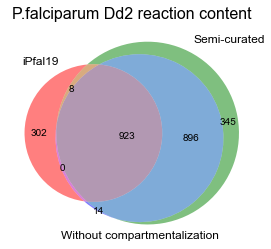

In [13]:

plt.figure()
#A = iPfal19
A = set([r.id for r in iPfal19.reactions])
#B = gf
B = set([r.id for r in pfalDd2_gf.reactions])
#C = gf_noC
C = set([r.id for r in pfalDd2_gf_noC.reactions])
Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)
plt.title("P.falciparum Dd2 reaction content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_Dd2_noC_reactions.png")

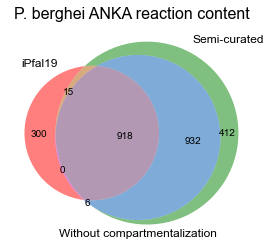

In [14]:

pfal3D7_gf = model_dict['gf_PbergheiANKA']
pfal3D7_gf_noC = model_dict['for_sensitivity_gf_PbergheiANKA']

plt.figure()
#A = iPfal19
A = set([r.id for r in iPfal19.reactions])
#B = gf
B = set([r.id for r in pfal3D7_gf.reactions])
#C = gf_noC
C = set([r.id for r in pfal3D7_gf_noC.reactions])
Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)

plt.title("P. berghei ANKA reaction content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_berghei_noC_reactions.png")

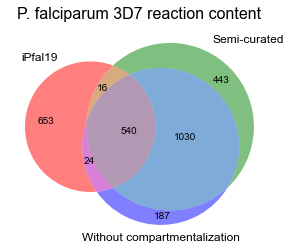

In [15]:

pfal3D7_gf = model_dict['gf_Pfalciparum3D7']
pfal3D7_gf_noC = model_dict['for_sensitivity_gf_Pfalciparum3D7']

plt.figure()
#A = iPfal19
A = set([r.id for r in iPfal19.reactions])
#B = gf
B = set([r.id for r in pfal3D7_gf.reactions])
#C = gf_noC
C = set([r.id for r in pfal3D7_gf_noC.reactions])
Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)

plt.title("P. falciparum 3D7 reaction content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_3D7_noC_reactions.png")

In [ ]:
# now switch to genes

In [16]:
# need to transform via orthology

mapping = pd.read_csv("/home/mac9jc/paradigm/data/plasmodium_orthology_conversion_release44.tsv", sep='\t')
mapping['Organism'] = mapping['Organism'].str.replace(".", "")
mapping['Organism'] = mapping['Organism'].str.replace("strain", "")
mapping['Organism'] = mapping['Organism'].str.replace("Strain", "")
mapping['Organism'] = mapping['Organism'].str.replace(" ", "")
#mapping['Organism'] = mapping['Organism'].str.replace("Sal-1", "Sal1")
#mapping['Organism'] = mapping['Organism'].str.replace("nilgiri","Nilgiri")

species_specific_mapping_Dd2 = mapping[mapping['Organism'] == 'PfalciparumDd2'].copy()
species_specific_mapping_ANKA = mapping[mapping['Organism'] == 'PbergheiANKA'].copy()
species_specific_mapping_Dd2.head()

,Gene ID,source_id,Organism,Product Description,Input Ortholog(s),Unnamed: 5
134746,PfDd2_000006200,PfDd2_000006200-t41_1,PfalciparumDd2,apicoplast ribosomal protein S4,PF3D7_API00100,NaN
134747,PfDd2_000006300:tRNA,PfDd2_000006300:tRNA-t41_1,PfalciparumDd2,His transfer RNA (gtg),PF3D7_API00200,NaN
134748,PfDd2_000006400:tRNA,PfDd2_000006400:tRNA-t41_1,PfalciparumDd2,Cys transfer RNA (gca),PF3D7_API00300,NaN
134749,PfDd2_000006500:tRNA,PfDd2_000006500:tRNA-t41_1,PfalciparumDd2,Met transfer RNA (cat),PF3D7_API00600,NaN
134750,PfDd2_000006600:tRNA,PfDd2_000006600:tRNA-t41_1,PfalciparumDd2,Tyr transfer RNA (gta),PF3D7_API00700,NaN


In [ ]:
species_specific_mapping_Dd2.columns

In [17]:

iPfal19_Dd2_genes = pd.DataFrame(columns = ['Gene ID', 'source_id', 'Organism', 'Product Description',
       'Input Ortholog(s)', 'Unnamed: 5']) 
for gene in iPfal19.genes:
    if  any(species_specific_mapping_Dd2['Input Ortholog(s)'].str.contains(gene.id)):
        new_gene = species_specific_mapping_Dd2[species_specific_mapping_Dd2['Input Ortholog(s)'].str.contains(gene.id)]
        iPfal19_Dd2_genes = pd.concat([iPfal19_Dd2_genes,new_gene])
iPfal19_Dd2_genes = iPfal19_Dd2_genes['Gene ID'].tolist()

iPfal19_PbANKA_genes = pd.DataFrame(columns = ['Gene ID', 'source_id', 'Organism', 'Product Description',
       'Input Ortholog(s)', 'Unnamed: 5']) 
for gene in iPfal19.genes:
    if  any(species_specific_mapping_ANKA['Input Ortholog(s)'].str.contains(gene.id)):
        new_gene = species_specific_mapping_ANKA[species_specific_mapping_ANKA['Input Ortholog(s)'].str.contains(gene.id)]
        iPfal19_PbANKA_genes = pd.concat([iPfal19_PbANKA_genes,new_gene])
iPfal19_PbANKA_genes = iPfal19_PbANKA_genes['Gene ID'].tolist()


In [18]:
print(len(iPfal19.genes))
print(len(iPfal19_Dd2_genes))
print(len(iPfal19_PbANKA_genes))

475
598
443


/home/mac9jc/.conda/envs/paradigm_env/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117 UserWarning: Bad circle positioning


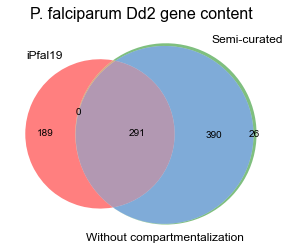

In [19]:
### HAVE TO TRANSOFRM VIA ORTHOLOGY
#A = iPfal19
plt.figure()
A = set(iPfal19_Dd2_genes)
#B = gf
B = set([r.id for r in pfalDd2_gf.genes])
#C = gf_noC
C = set([r.id for r in pfalDd2_gf_noC.genes])
Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)

plt.title("P. falciparum Dd2 gene content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_Dd1_noC_genes.png")

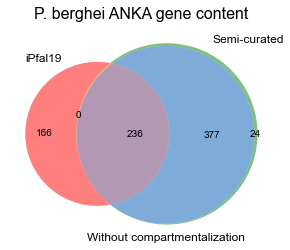

In [20]:
### HAVE TO TRANSOFRM VIA ORTHOLOGY
pfal3D7_gf = model_dict['gf_PbergheiANKA']
pfal3D7_gf_noC = model_dict['for_sensitivity_gf_PbergheiANKA']

#A = iPfal19
plt.figure()
A = set(iPfal19_PbANKA_genes)
#B = gf
B = set([r.id for r in pfal3D7_gf.genes])
#C = gf_noC
C = set([r.id for r in pfal3D7_gf_noC.genes])
Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)

plt.title("P. berghei ANKA gene content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_berghei_noC_genes.png")

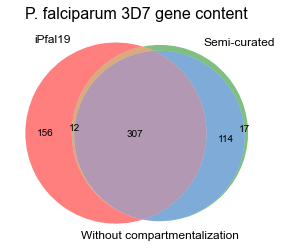

In [21]:

pfal3D7_gf = model_dict['gf_Pfalciparum3D7']
pfal3D7_gf_noC = model_dict['for_sensitivity_gf_Pfalciparum3D7']

#A = iPfal19
plt.figure()
A = set([r.id for r in iPfal19.genes])
#B = gf
B_temp = [r.id for r in pfal3D7_gf.genes]
B = [item for item in B_temp if '.' not in item and ":" not in item]
B_split1 = [item.split('.')[0] for item in B_temp if '.' in item]
B_split2 = [item.split(':')[0] for item in B_temp if ':' in item]
B.extend(B_split1)
B.extend(B_split2)
B = set(B)
#C = gf_noC
C_temp = [r.id for r in pfal3D7_gf_noC.genes]
C = [item for item in C_temp if '.' not in item and ":" not in item]
C_split1 = [item.split('.')[0] for item in C_temp if '.' in item]
C_split2 = [item.split(':')[0] for item in C_temp if ':' in item]
C.extend(C_split1)
C.extend(C_split2)
C = set(C)

Abc = len(A.difference(B).difference(C))
aBc = len(B.difference(A).difference(C))
ABc = len(A.intersection(B).difference(C))
abC = len(C.difference(A).difference(B))
AbC = len(A.intersection(C).difference(B))
aBC = len(B.intersection(C).difference(A))
ABC = len(A.intersection(B).intersection(C))

#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), 
      set_labels = ('iPfal19', 'Semi-curated','Without compartmentalization'), alpha = 0.5)

plt.title("P. falciparum 3D7 gene content")

plt.savefig("/home/mac9jc/paradigm/data/results/figures_for_reviewers/venn_3D7_noC_genes.png")